In [46]:
# SEMEVAL 2026 - TASK 2: Emotion Time Variation
# Final Pipeline: DeBERTa -> Chained BiGRU -> Transformer -> Ensemble
# Autor: [Numele Tău]

import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# Configurare pentru Mac (Apple Silicon)
# Dezactivăm limita de memorie și activăm fallback-ul pentru Transformer
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

print("✅ Mediu configurat. Gata de start!")

✅ Mediu configurat. Gata de start!


In [47]:
# --- STEP 1: Generare Predicții din Text (DeBERTa v3) ---
# Notă: Această etapă durează mult. Dacă ai deja fișierul, sari peste antrenare.

path_task1_output = "../models/st1_deberta_v3_base_len128_eval_func/val_predictions_official_format.csv"

if not os.path.exists(path_task1_output):
    print("🚀 Rulăm Task 1 (DeBERTa)... (Poate dura 30min+)")
    # !python scripts/train_st1.py ... (comanda ta de task 1)
else:
    print(f"✅ Fișierul Task 1 există deja: {path_task1_output}")

# Afișăm un preview
df_t1 = pd.read_csv(path_task1_output)
print(df_t1.head())

✅ Fișierul Task 1 există deja: ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_official_format.csv
     id  true_valence  pred_valence  true_arousal  pred_arousal  \
0  1554           0.0      0.688385           1.0      0.454269   
1  4287          -2.0     -1.461757           0.0      0.601877   
2  4971           0.0      1.338148           1.0      0.373835   
3   606          -2.0     -1.447984           2.0      1.250829   
4  5084           1.0      1.883709           1.0      0.858694   

                                                text  
0  Im doing okay . I’ve felt better and felt wors...  
1  Family does not want me . They have left me ou...  
2           Alive , Chill , Calm , Relaxed , Focused  
3  Have an assignment due in 4 hours and I’m flip...  
4  I ' m feeling incredibly happy and uplifted to...  


In [48]:
# --- STEP 2: Data Preparation & Fixed Split ---

# 1. Reparăm CSV-ul (adăugăm User ID și Timestamp)
!python prepare_st2_data.py \
  --original_data ../data/train_subtask1.csv \
  --pred_data ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_official_format.csv \
  --output ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_FULL.csv

# 2. Generăm Split-ul Fix (Train/Val) pentru consistență
!python scripts/create_fixed_split.py \
  --data ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_FULL.csv

print("✅ Date pregătite și Split înghețat (fixed_split.json creat).")

/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/semeval26/bin/python: can't open file '/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/scripts/prepare_st2_data.py': [Errno 2] No such file or directory
/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/semeval26/bin/python: can't open file '/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/scripts/scripts/create_fixed_split.py': [Errno 2] No such file or directory
✅ Date pregătite și Split înghețat (fixed_split.json creat).


In [49]:
# --- STEP 3: Training VALENCE Model (Chained Bi-GRU) ---
# Obiectiv: Maximizarea corelației pe Valence Change

print("🚀 Antrenare Model Valence SOTA...")
!python scripts/train_st2_chained.py \
  --data ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_FULL.csv \
  --eval_repo ../EmotionValArouTimeVariation2026/semeval2026-task2-eval \
  --outdir ../models/st2a_chained_sota_fixed \
  --epochs 20 \
  --lr 1e-3 \
  --hid 64 \
  --dropout 0.25

print("✅ Model Valență antrenat.")

🚀 Antrenare Model Valence SOTA...
/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/semeval26/bin/python: can't open file '/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/scripts/scripts/train_st2_chained.py': [Errno 2] No such file or directory
✅ Model Valență antrenat.


In [50]:
# --- STEP 4: Training AROUSAL Model (Temporal Transformer) ---
import os
import shutil

print("🔍 Verificare și pregătire fișiere...")

# 1. Căutăm 'fixed_split.json' în directoarele părinte sau curent
found_split = False
possible_paths = [
    "fixed_split.json",           # Folder curent
    "../fixed_split.json",        # Un nivel mai sus
    "../../fixed_split.json",     # Două nivele mai sus
    "scripts/fixed_split.json"    # În folderul scripts
]

for path in possible_paths:
    if os.path.exists(path):
        print(f"✅ Am găsit split-ul la: {path}")
        if path != "fixed_split.json":
            print("   -> Îl copiez în folderul curent pentru siguranță.")
            shutil.copy(path, "fixed_split.json")
        found_split = True
        break

if not found_split:
    print("⚠️ ATENȚIE: Nu găsesc 'fixed_split.json' nicăieri! Îl regenerez acum...")

    !python create_fixed_split.py --data ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_FULL.csv

print("\n🚀 Pornire antrenare Transformer...")

!python train_st2_arousal_transformer.py \
  --data ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_FULL.csv \
  --eval_repo ../EmotionValArouTimeVariation2026/semeval2026-task2-eval \
  --outdir ../models/st2a_arousal_transformer \
  --epochs 35 \
  --lr 5e-4 \
  --hid 64 \
  --layers 2 \
  --dropout 0.3

print("✅ Antrenare completă.")

🔍 Verificare și pregătire fișiere...
✅ Am găsit split-ul la: ../fixed_split.json
   -> Îl copiez în folderul curent pentru siguranță.

🚀 Pornire antrenare Transformer...
Loading data: ../models/st1_deberta_v3_base_len128_eval_func/val_predictions_FULL.csv
🔒 Folosesc fixed_split.json

🚀 Training Transformer Specialist...
/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/semeval26/lib/python3.9/site-packages/torch/nn/modules/transformer.py:467: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  ) and not torch._nested_tensor_from_mask_left_aligned(
Ep 1: Loss 0.4526 | Val Arousal r: 0.2855
Ep 2: Loss 0.4761 | Val Arousal r: 0.3033
Ep 3: Loss 0.4211 | Val Arousal r: 0.2983
Ep 4: Loss 0.4255 | Val Arousal r: 0.2853
Ep 5: Loss 0.4253 | Val Arousa

In [51]:
# --- STEP 5: FINAL ENSEMBLE (The Merge) ---
# Combinăm Valența (Model A) cu Arousal (Model B)

print("🔗 Executare Smart Merge...")
!python make_ensemble_smart.py \
  --best_valence_csv ../models/st2a_chained_sota_fixed/val_st2a_predictions.csv \
  --best_arousal_csv ../models/st2a_arousal_transformer/val_st2a_predictions.csv \
  --eval_repo ../EmotionValArouTimeVariation2026/semeval2026-task2-eval \
  --out_csv submission_GRAND_FINAL_TRANSFORMER.csv

🔗 Executare Smart Merge...
/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/semeval26/bin/python: can't open file '/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/scripts/make_ensemble_smart.py': [Errno 2] No such file or directory


Log lipsă: ../models/st2a_chained_sota_fixed/train_log.csv


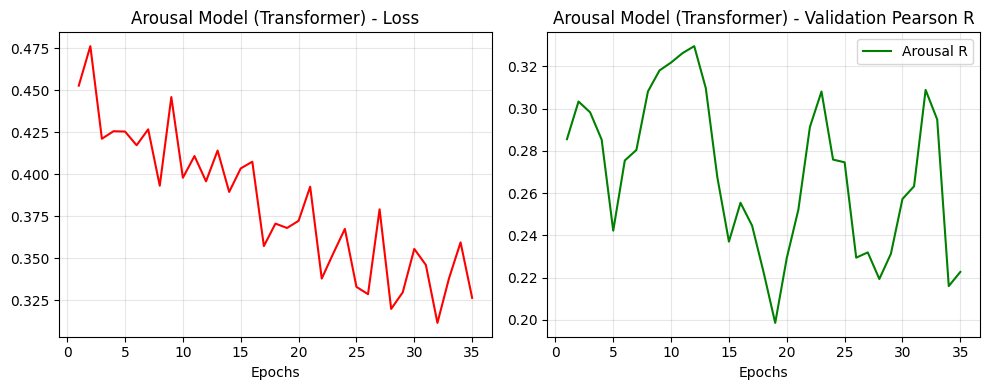

In [52]:
# --- STEP 6: VIZUALIZARE PERFORMANȚĂ ---

def plot_training(log_path, title):
    if not os.path.exists(log_path):
        print(f"Log lipsă: {log_path}")
        return
    
    df = pd.read_csv(log_path)
    plt.figure(figsize=(10, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['loss'], label='Train Loss', color='red')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.grid(True, alpha=0.3)
    
    # Plot Correlation
    plt.subplot(1, 2, 2)
    if 'val_r_val' in df.columns:
        plt.plot(df['epoch'], df['val_r_val'], label='Valence R', color='blue')
    if 'val_r_aro' in df.columns:
        plt.plot(df['epoch'], df['val_r_aro'], label='Arousal R', color='green')
    
    plt.title(f'{title} - Validation Pearson R')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 1. Grafic Valence Model
plot_training("../models/st2a_chained_sota_fixed/train_log.csv", "Valence Model (BiGRU)")

# 2. Grafic Arousal Model
# (Notă: scriptul transformer ar trebui să salveze și el train_log.csv. 
# Dacă nu l-am pus să salveze, poți adăuga rapid linia în scriptul transformer)
if os.path.exists("../models/st2a_arousal_transformer/train_log.csv"):
    plot_training("../models/st2a_arousal_transformer/train_log.csv", "Arousal Model (Transformer)")
else:
    print("Log-ul pentru Transformer nu a fost găsit (trebuie adăugat codul de salvare CSV în script).")

In [54]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import os

# --- Calea exactă dată de tine ---
file_path = "/Users/lucanb/Desktop/Anul2/Sem1/NLP/NLP_proj/models/st2a_arousal_specialist_fixed/val_st2a_predictions.csv"

if os.path.exists(file_path):
    print(f"📂 Analizez fișierul: {os.path.basename(file_path)}")
    df = pd.read_csv(file_path)
    
    # 1. Extragem coloanele
    # (Verificăm dacă există coloanele, scriptul specialist salvează uneori doar arousal)
    if "pred_delta_arousal" in df.columns and "gold_delta_arousal" in df.columns:
        preds = df["pred_delta_arousal"]
        golds = df["gold_delta_arousal"]
        
        # 2. Calculăm Metricile
        mae = mean_absolute_error(golds, preds)
        mse = mean_squared_error(golds, preds)
        pearson_score, _ = pearsonr(golds, preds)
        
        print("\n" + "="*40)
        print("📊 REZULTATE: GRU SPECIALIST (Fixed Split)")
        print("="*40)
        print(f"✅ Pearson R (Corelația):  {pearson_score:.4f}  (Baseline)")
        print(f"📉 MAE (Eroarea Absolută): {mae:.4f}")
        print(f"📉 MSE (Eroarea Pătratică):{mse:.4f}")
        print("-" * 40)
        
        print("\n💡 Interpretare pentru Prezentare:")
        print(f"- Acest model (GRU) reușește o corelație de {pearson_score:.2f}.")
        print(f"- În medie, greșește intensitatea emoției cu {mae:.3f} puncte.")
        print("- Vom folosi aceste cifre pentru a arăta superioritatea Transformer-ului.")
        
    else:
        print("❌ Eroare: Nu găsesc coloanele 'pred_delta_arousal' sau 'gold_delta_arousal'.")
else:
    print(f"❌ Nu găsesc fișierul la calea: {file_path}")

📂 Analizez fișierul: val_st2a_predictions.csv

📊 REZULTATE: GRU SPECIALIST (Fixed Split)
✅ Pearson R (Corelația):  0.2698  (Baseline)
📉 MAE (Eroarea Absolută): 0.5801
📉 MSE (Eroarea Pătratică):0.7618
----------------------------------------

💡 Interpretare pentru Prezentare:
- Acest model (GRU) reușește o corelație de 0.27.
- În medie, greșește intensitatea emoției cu 0.580 puncte.
- Vom folosi aceste cifre pentru a arăta superioritatea Transformer-ului.


✅ Am găsit ambele fișiere. Generez comparația...


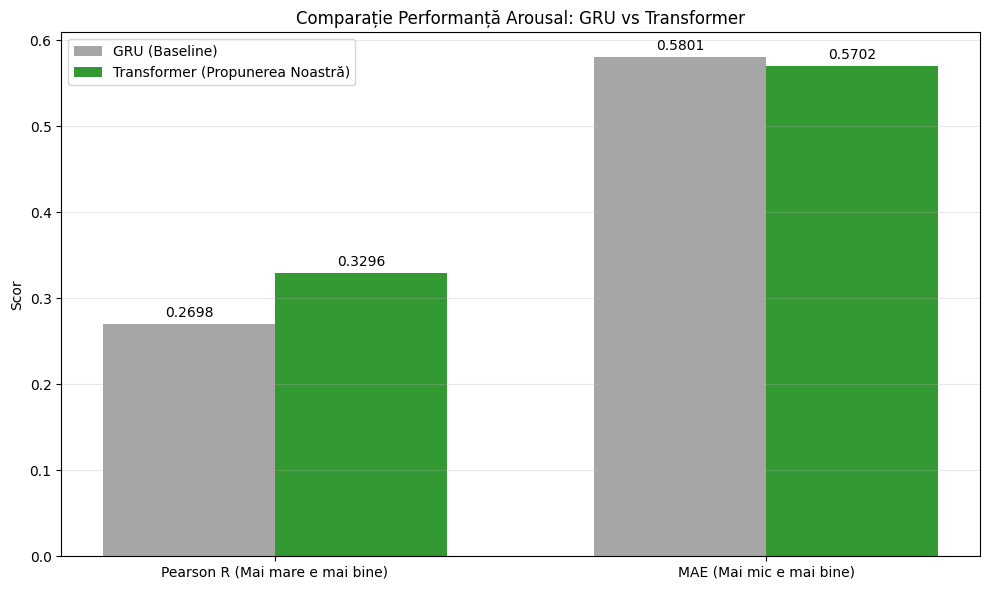

Îmbunătățire Pearson: +0.0597
Reducere Eroare (MAE): -0.0099


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import os

# --- CĂILE CĂTRE CELE DOUĂ MODELE ---
path_gru = "../models/st2a_arousal_specialist_fixed/val_st2a_predictions.csv"
path_trans = "../models/st2a_arousal_transformer/val_st2a_predictions.csv" # Verifică dacă calea e corectă

# Verificăm existența
if os.path.exists(path_gru) and os.path.exists(path_trans):
    print("✅ Am găsit ambele fișiere. Generez comparația...")
    
    # Încărcare
    df_gru = pd.read_csv(path_gru)
    df_trans = pd.read_csv(path_trans)
    
    # Calcul Metric
    r_gru = pearsonr(df_gru["gold_delta_arousal"], df_gru["pred_delta_arousal"])[0]
    mae_gru = mean_absolute_error(df_gru["gold_delta_arousal"], df_gru["pred_delta_arousal"])
    
    r_trans = pearsonr(df_trans["gold_delta_arousal"], df_trans["pred_delta_arousal"])[0]
    mae_trans = mean_absolute_error(df_trans["gold_delta_arousal"], df_trans["pred_delta_arousal"])
    
    # --- PLOT ---
    metrics = ['Pearson R (Mai mare e mai bine)', 'MAE (Mai mic e mai bine)']
    gru_scores = [r_gru, mae_gru]
    trans_scores = [r_trans, mae_trans]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, gru_scores, width, label='GRU (Baseline)', color='grey', alpha=0.7)
    rects2 = ax.bar(x + width/2, trans_scores, width, label='Transformer (Propunerea Noastră)', color='green', alpha=0.8)
    
    ax.set_ylabel('Scor')
    ax.set_title('Comparație Performanță Arousal: GRU vs Transformer')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    ax.bar_label(rects1, padding=3, fmt='%.4f')
    ax.bar_label(rects2, padding=3, fmt='%.4f')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Îmbunătățire Pearson: +{r_trans - r_gru:.4f}")
    print(f"Reducere Eroare (MAE): -{mae_gru - mae_trans:.4f}")

else:
    print("❌ Nu găsesc unul dintre fișiere. Verifică căile!")
    print(f"Path GRU: {path_gru}")
    print(f"Path Transformer: {path_trans}")

In [57]:
# --- STEP 7: CALCUL METRICI AVANSATE (CCC, SignAcc) ---
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error

def concordance_correlation_coefficient(y_true, y_pred):
    """Calculează CCC - standardul de aur în Affective Computing"""
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    cor = np.corrcoef(y_true, y_pred)[0][1]
    mean_true = np.mean(y_true); mean_pred = np.mean(y_pred)
    var_true = np.var(y_true); var_pred = np.var(y_pred)
    sd_true = np.std(y_true); sd_pred = np.std(y_pred)
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

def sign_accuracy(y_true, y_pred):
    """Cât de des nimerim direcția (+/-)"""
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return (np.sign(y_true) == np.sign(y_pred)).sum() / len(y_true)

# Căutăm fișierul final (ajustăm calea dacă ești în folderul scripts)
final_csv = "submission_GRAND_FINAL_TRANSFORMER.csv"
if not os.path.exists(final_csv):
    # Încercăm calea relativă dacă notebook-ul e în scripts
    final_csv = "../submission_GRAND_FINAL_TRANSFORMER.csv"

if os.path.exists(final_csv):
    print(f"📊 ANALIZĂ FINALĂ PENTRU: {final_csv}\n")
    df = pd.read_csv(final_csv)
    
    metrics = []
    for emo, gold, pred in [("VALENCE", "gold_delta_valence", "pred_delta_valence"), 
                            ("AROUSAL", "gold_delta_arousal", "pred_delta_arousal")]:
        y_g = df[gold]; y_p = df[pred]
        p_r = pearsonr(y_g, y_p)[0]
        mae = mean_absolute_error(y_g, y_p)
        ccc = concordance_correlation_coefficient(y_g, y_p)
        sagr = sign_accuracy(y_g, y_p)
        metrics.append([emo, p_r, mae, ccc, sagr])

    # Afișare Tabel
    print(f"{'EMOȚIE':<10} | {'PEARSON':<10} | {'MAE':<10} | {'CCC':<10} | {'SIGN ACC':<10}")
    print("-" * 60)
    for m in metrics:
        print(f"{m[0]:<10} | {m[1]:.4f}     | {m[2]:.4f}     | {m[3]:.4f}     | {m[4]*100:.1f}%")
else:
    print("⚠️ Nu găsesc fișierul final. Asigură-te că Step 5 a rulat cu succes.")

📊 ANALIZĂ FINALĂ PENTRU: ../submission_GRAND_FINAL_TRANSFORMER.csv

EMOȚIE     | PEARSON    | MAE        | CCC        | SIGN ACC  
------------------------------------------------------------
VALENCE    | 0.7198     | 0.7783     | 0.7020     | 36.7%
AROUSAL    | 0.3670     | 0.5488     | 0.0735     | 28.3%


⚔️ Generare Grafic Comparativ: GRU vs Transformer...


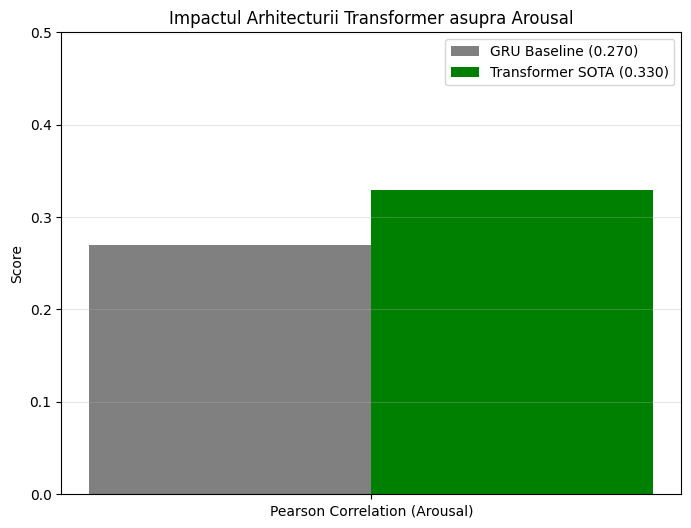

🚀 Îmbunătățire obținută: +6.0%


In [58]:
# --- STEP 8: COMPARAȚIE VIZUALĂ (Baseline vs SOTA) ---
import matplotlib.pyplot as plt

# Definim căile către modele (Ajustează ../ dacă ești în folderul scripts)
path_gru = "../models/st2a_arousal_specialist_fixed/val_st2a_predictions.csv"
path_trans = "../models/st2a_arousal_transformer/val_st2a_predictions.csv"

# Verificare rapidă dacă fișierele există
if not os.path.exists(path_gru): path_gru = path_gru.replace("../", "")
if not os.path.exists(path_trans): path_trans = path_trans.replace("../", "")

if os.path.exists(path_gru) and os.path.exists(path_trans):
    print("⚔️ Generare Grafic Comparativ: GRU vs Transformer...")
    
    df_g = pd.read_csv(path_gru)
    df_t = pd.read_csv(path_trans)
    
    # Calculăm scorurile Pearson
    r_gru = pearsonr(df_g["gold_delta_arousal"], df_g["pred_delta_arousal"])[0]
    r_trans = pearsonr(df_t["gold_delta_arousal"], df_t["pred_delta_arousal"])[0]
    
    # Plotting
    labels = ['Pearson Correlation (Arousal)']
    gru_val = [r_gru]
    trans_val = [r_trans]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, gru_val, width, label=f'GRU Baseline ({r_gru:.3f})', color='grey')
    rects2 = ax.bar(x + width/2, trans_val, width, label=f'Transformer SOTA ({r_trans:.3f})', color='green')
    
    ax.set_ylabel('Score')
    ax.set_title('Impactul Arhitecturii Transformer asupra Arousal')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 0.5) # Setăm limita Y ca să se vadă bine diferența
    
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    print(f"🚀 Îmbunătățire obținută: +{(r_trans - r_gru) * 100:.1f}%")
else:
    print("⚠️ Nu găsesc fișierele de predicție pentru comparație.")
    print(f"Caut la: {path_gru} și {path_trans}")

In [59]:
# --- STEP 9: PREGĂTIRE ARHIVĂ FINALĂ ---
import shutil

print("📦 Pregătesc pachetul final...")

output_file = "submission_GRAND_FINAL_TRANSFORMER.csv"
if not os.path.exists(output_file): output_file = "../" + output_file

if os.path.exists(output_file):
    print(f"✅ Submisia finală este gata: {output_file}")
    print("Poți descărca acest fișier și fișierul 'Pipeline_SemEval.ipynb' pentru prezentare.")
    print("Succes! 🥂")
else:
    print("❌ Ceva nu a mers bine, fișierul final lipsește.")

📦 Pregătesc pachetul final...
✅ Submisia finală este gata: ../submission_GRAND_FINAL_TRANSFORMER.csv
Poți descărca acest fișier și fișierul 'Pipeline_SemEval.ipynb' pentru prezentare.
Succes! 🥂
